In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, \
    GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split

from scipy.stats import spearmanr

In [3]:
dataset_path = '../data/model_data.h5'

# Load Data

In [4]:
data = pd.read_hdf(dataset_path, 'no_dummies')

In [5]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)
data

,Close,Volume,Open,High,Low,Consumption in mcf,Storage in mcf,US Gross Withdrawal in mcf,Other Gross Withdrawal in mcf,RSI,...,return_21d,return_42d,return_63d,target_1d,target_5d,target_10d,target_21d,year,month,weekday
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-09,2.107,108772.0,2.103,2.117,2.065,1953071.0,2478.0,2417498.0,93400.0,34.901425,...,-0.003584,-0.003797,-0.005916,-0.036070,-0.015267,-0.006449,0.007501,2012,4,0
2012-04-10,2.031,120126.0,2.111,2.125,2.025,1953071.0,2478.0,2417498.0,93400.0,30.556017,...,-0.006397,-0.004436,-0.006230,-0.023634,-0.008005,0.001807,0.009692,2012,4,1
2012-04-12,1.983,188668.0,1.976,2.068,1.972,1953071.0,2478.0,2417498.0,93400.0,28.170441,...,-0.006395,-0.005282,-0.006237,-0.001009,-0.007785,0.002641,0.011266,2012,4,3
2012-04-13,1.981,111947.0,1.982,1.999,1.959,1953071.0,2503.0,2417498.0,93400.0,28.072097,...,-0.007064,-0.005306,-0.005330,0.017668,-0.005512,0.009896,0.009795,2012,4,4
2012-04-16,2.016,115321.0,1.986,2.030,1.977,1953071.0,2503.0,2417498.0,93400.0,32.512260,...,-0.005926,-0.004447,-0.004609,-0.032242,-0.000894,0.012604,0.010299,2012,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24,3.896,54557.0,3.929,3.970,3.884,2218011.0,2851.0,3396062.0,32500.0,50.393336,...,-0.002451,0.003121,0.004626,0.000257,0.023556,0.023485,0.011719,2021,8,1
2021-08-25,3.897,37979.0,3.900,3.991,3.858,2218011.0,2851.0,3396062.0,32500.0,50.456830,...,-0.000895,0.002589,0.004246,0.073646,0.034399,0.025870,0.013270,2021,8,2
2021-08-26,4.184,64362.0,3.917,4.217,3.896,2218011.0,2851.0,3396062.0,32500.0,64.500602,...,0.001622,0.003632,0.005519,0.044455,0.020949,0.016707,0.014884,2021,8,3


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2351 entries, 2012-04-09 to 2021-08-30
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Close                          2351 non-null   float64
 1   Volume                         2351 non-null   float64
 2   Open                           2351 non-null   float64
 3   High                           2351 non-null   float64
 4   Low                            2351 non-null   float64
 5   Consumption in mcf             2351 non-null   float64
 6   Storage in mcf                 2351 non-null   float64
 7   US Gross Withdrawal in mcf     2351 non-null   float64
 8   Other Gross Withdrawal in mcf  2351 non-null   float64
 9   RSI                            2351 non-null   float64
 10  ATR                            2351 non-null   float64
 11  MACD                           2351 non-null   float64
 12  return_1d                     

In [7]:
columns_to_drop = ['Open', 'Close', 'Low', 'High', 'Volume']
y = data.filter(like='target')
X = data.drop(columns_to_drop, axis=1)
X = X.drop(y.columns, axis=1)

In [9]:
X, X_test, y, y_test = X.loc['2012':'2019'], X.loc['2019':'2021'], y.loc['2012':'2019'], y.loc['2019':'2021']

In [10]:
f'Train lenght: {len(X)}', f'Test length: {len(X_test)}'

('Train lenght: 1932', 'Test length: 671')

In [11]:
X_test

,Consumption in mcf,Storage in mcf,US Gross Withdrawal in mcf,Other Gross Withdrawal in mcf,RSI,ATR,MACD,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,year,month,weekday
Date,,,,,,,,,,,,,,,,
2019-01-02,3409295.0,2705.0,3384552.0,40363.0,33.538191,0.299760,-0.233675,0.006122,-0.031256,-0.017467,-0.020928,-0.002319,-0.001078,2019,1,2
2019-01-03,3409295.0,2705.0,3384552.0,40363.0,33.358741,0.287848,-0.258615,-0.004395,-0.036298,-0.026137,-0.018285,-0.002248,-0.001465,2019,1,3
2019-01-04,3409295.0,2614.0,3384552.0,40363.0,36.160111,0.278359,-0.267889,0.033616,-0.035236,-0.020013,-0.017993,-0.001805,-0.000619,2019,1,4
2019-01-07,3409295.0,2614.0,3384552.0,40363.0,34.578907,0.268048,-0.279667,-0.032852,-0.022750,-0.019451,-0.019680,-0.004560,-0.001038,2019,1,0
2019-01-08,3409295.0,2614.0,3384552.0,40363.0,35.279894,0.256687,-0.284057,0.007812,0.001830,-0.024851,-0.017807,-0.004296,-0.001528,2019,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24,2218011.0,2851.0,3396062.0,32500.0,50.393336,0.132758,0.022960,-0.012421,0.003057,-0.004823,-0.002451,0.003121,0.004626,2021,8,1
2021-08-25,2218011.0,2851.0,3396062.0,32500.0,50.456830,0.132775,0.019566,0.000257,0.002326,-0.004065,-0.000895,0.002589,0.004246,2021,8,2
2021-08-26,2218011.0,2851.0,3396062.0,32500.0,64.500602,0.146220,0.038202,0.073646,0.017838,0.006206,0.001622,0.003632,0.005519,2021,8,3


In [12]:

class MultipleTimeSeriesCV(BaseCrossValidator):
    """Generates tuples of train_idx, test_idx pairs"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Date > days[train_start])
                              & (dates.Date <= days[train_end])].index
            test_idx = dates[(dates.Date > days[test_start])
                             & (dates.Date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [13]:
n_splits = 15
train_period_length = 300
test_period_length = 100
lookaheads = [1, 5, 10, 21]

In [14]:
# Utilities functions

def display_score(scores):
    print('scores: ',scores)
    print('mean: ', scores.mean())
    print('standard deviation: ', scores.std())


def rank_correl(y, y_pred):
    return spearmanr(y, y_pred, axis=None)[0]

ic = make_scorer(rank_correl)


def get_cross_val_score(model, X, y, score_fun, cv, n_jobs=-1):
    cv_score = cross_val_score(estimator=model,
                           X=X,
                           y=y,
                           scoring=score_fun,
                           cv=cv,
                           n_jobs=n_jobs,
                           verbose=1)
    display_score(cv_score)

# Decision Tree Regressor

In [15]:
dt_reg = DecisionTreeRegressor(max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='auto')


In [16]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(dt_reg, X, y, ic, cv)
    print('\n')

lookhead: 1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.13074045  0.12492183  0.08368874 -0.10645077  0.01586788  0.05062417
  0.08113088  0.08762132 -0.02384717  0.06771473  0.13449861  0.12878588
 -0.05508925  0.04978284  0.20585735]
mean:  0.04762443937472875
standard deviation:  0.0901136902414585


lookhead: 5


[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.21331421  0.04049832  0.14663152 -0.04377866  0.00572394  0.13455451
  0.12513679  0.21395705 -0.05071943  0.16881264 -0.05607249 -0.16088476
  0.1670477   0.067999    0.10593405]
mean:  0.04343506439058108
standard deviation:  0.12266075223604475


lookhead: 10
scores:  [-0.1890559   0.0425283   0.20133028 -0.07271154  0.00881408  0.05380674
  0.14232117  0.24819007  0.04086663  0.18846036  0.16142688 -0.05721388
  0.12855176  0.02017232  0.07656788]
mean:  0.06627034436974852
standard deviation:  0.1130298822418843


lookhead: 21
scores:  [-1.45077550e-01  2.00434258e-01  1.03402071e-01  7.82803513e-02
  5.30655008e-05 -4.92176406e-02 -1.04873648e-02  2.33899622e-01
  1.75797547e-03 -2.30778040e-02  8.79623900e-03  6.62144117e-02
  6.99795031e-02 -4.49174367e-02 -1.76967828e-02]
mean:  0.031489527899705064
standard deviation:  0.09403333142049759




[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.2s finished


# Random Forest Regressor

In [17]:
rf_reg = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1,
                                random_state=None,
                                verbose=0,
                                warm_start=False)

In [18]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(rf_reg, X, y, ic, cv)
    print('\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


lookhead: 1


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.1335989   0.31659621  0.28098573 -0.08652439  0.12367371  0.18486584
  0.12659791  0.16286952 -0.00595241  0.15589823 -0.00601504  0.16172448
  0.07641742  0.11647629  0.20405434]
mean:  0.11187126310760069
standard deviation:  0.12121409761475863


lookhead: 5


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.14459397  0.30077674  0.29527567 -0.04063216  0.0838974   0.21976469
  0.12946228  0.14304221 -0.01286165  0.07741436  0.0006645   0.1307834
  0.13651229  0.12051882  0.14950762]
mean:  0.10596881358419391
standard deviation:  0.1163628875909105


lookhead: 10


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.14551216  0.32378876  0.27034794 -0.03364202  0.05494066  0.08294527
  0.12092544  0.15689967  0.09547749  0.09429012 -0.00635835  0.16149985
  0.11301164  0.11532372  0.07556185]
mean:  0.09863332495969866
standard deviation:  0.10934764353500782


lookhead: 21
scores:  [-0.14811543  0.27001136  0.1804379   0.12187089  0.10972381  0.02976581
  0.07514317  0.14147263  0.09523393  0.02031866  0.01826955  0.08681925
  0.08962837  0.12611854  0.05999531]
mean:  0.08511291733232398
standard deviation:  0.08834407268021012




[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.8s finished


# Ada Boosting Regressor

In [19]:
ada_reg = AdaBoostRegressor(n_estimators=100,
                            loss='square')

In [20]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(ada_reg, X, y[f'target_{lookahead}d'], ic, cv)
    print('\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


lookhead: 1


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.07641383 -0.0484917   0.17778822 -0.00149484 -0.10004057  0.03376641
  0.088141   -0.04996398  0.07006979  0.06962454  0.0325713  -0.04662875
  0.03517372 -0.02162944  0.03511089]
mean:  0.013172183573155399
standard deviation:  0.07049473214329544


lookhead: 5


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.32453056 -0.05217695  0.29779305  0.12412868 -0.03200653  0.12724716
  0.04915647  0.15222565  0.16206937 -0.00448449  0.05397748  0.13580151
 -0.07524071 -0.00723691 -0.0569482 ]
mean:  0.036651665895994515
standard deviation:  0.1393760118513732


lookhead: 10


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.15417231  0.39518054  0.07360119  0.22608188  0.2149316   0.2800005
  0.19137596  0.20170888  0.43201532  0.12287872  0.25544976  0.09731396
  0.02458028  0.3567428  -0.05707512]
mean:  0.17737426370042328
standard deviation:  0.15791089570200809


lookhead: 21
scores:  [-0.2941374   0.76636882  0.21533303  0.28108083  0.36955513  0.53050747
  0.14830835 -0.36835489 -0.00587161  0.01837721  0.02521319  0.77101789
 -0.06472651  0.60686306 -0.13350749]
mean:  0.19106847265704496
standard deviation:  0.34766537714703527




[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.6s finished


# Gradient Boosting Regressor

In [21]:
grad_reg = GradientBoostingRegressor(n_estimators=250,
                                        max_depth=None,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        random_state=None,
                                        verbose=0,
                                        warm_start=False)

In [22]:
for lookahead in lookaheads:
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)
    print(f'lookhead: {lookahead}')
    get_cross_val_score(grad_reg, X, y[f'target_{lookahead}d'], ic, cv)
    print('\n')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


lookhead: 1


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.21951461  0.01845785  0.14397456  0.00547856  0.02443444  0.18144614
  0.00538255  0.01066907  0.04754933  0.26383438  0.02372637 -0.02694878
  0.12732073  0.17417342 -0.0439844 ]
mean:  0.049066641558095044
standard deviation:  0.11209395861498782


lookhead: 5


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.44668473  0.05172517 -0.00681717 -0.21033303  0.02990699  0.12136469
 -0.07331555  0.19301588 -0.07256743  0.10672667  0.12554044 -0.05168917
  0.1520072  -0.00054005 -0.03392739]
mean:  -0.007705833093504989
standard deviation:  0.15560611642119698


lookhead: 10


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [-0.31142062  0.08693878  0.07518797  0.09252925  0.19397056  0.2039604
  0.14367837 -0.01727014  0.51471519 -0.02993099  0.22646004 -0.14157986
  0.09663395  0.18277937 -0.21965797]
mean:  0.0731329545063984
standard deviation:  0.19439622864242923


lookhead: 21
scores:  [-0.15269219 -0.24408861  0.22130213  0.19447945  0.27908791  0.42410568
 -0.40422685 -0.54669995  0.17669367 -0.09275811 -0.10383875 -0.10277828
 -0.01890863  0.19171917  0.46689149]
mean:  0.019219210024065035
standard deviation:  0.2828967138385509




[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.4s finished


It seems like that the most robust learner is the `RandomTreesRegressor`, since there is not much deviation using the
various targets. Let's fine tune it in order to find the bests parameters

## Hyperparamter Options

In [23]:
n_estimators = [100, 250]
max_depth = [5, 15, None]
min_samples_leaf = [5, 25, 100]

In [24]:
from itertools import product

cv_params = list(product(n_estimators,
                         max_depth,
                         min_samples_leaf))
n_cv_params = len(cv_params)
n_cv_params

18

In [25]:
sample_proportion = .6
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)),
                                     size=int(sample_size),
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 10


## Train/Test Period Lenghts

In [26]:
YEAR = 252
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

In [27]:
test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)
print('# period params: ', n_test_params)

# period params:  10


## Run cross-validation

In [28]:
labels = sorted(y.columns)
features = X.columns.tolist()
lookaheads = [1, 5, 10, 21]

In [29]:
label_dict = dict(zip(lookaheads, labels))

In [30]:
cross_val_cols = [
    'train_length',
    'test_length',
    'n_estimators',
    'max_depth',
    'min_samples_leaf',
    'mean_ic',
    'std_ic',
    'rounds',
    'target'
]

cross_val_results = pd.DataFrame(columns=cross_val_cols)

In [31]:
run_cross_val = False

if run_cross_val:
    for lookahead in lookaheads:
        for train_length, test_length in test_params:
            n_splits = int(7 * YEAR / (train_length + test_length))
            res_row = dict(zip(cross_val_results, [None] * len(cross_val_results)))

            cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                      test_period_length=test_length,
                                      train_period_length=train_length,
                                      lookahead=lookahead)

            res_row['target'] = lookahead
            res_row['train_length'] = train_length
            res_row['test_length'] = test_length


            for p, (n_estimator, max_d, min_s_l) in enumerate(cv_params_):
                base_params = rf_reg.get_params()
                model = RandomForestRegressor(base_params)
                model_params = {
                    'n_estimators': n_estimator,
                    'max_depth': max_d,
                    'max_features': 'log2',
                    'min_samples_leaf': min_s_l
                }
                model = model.set_params(**model_params)

                cval_score = cross_val_score(
                    estimator=model,
                    X=X,
                    y=y,
                    cv=cv,
                    n_jobs=-1,
                    scoring=ic
                )

                for k, v in model_params.items():
                    res_row[k] = v

                res_row['mean_ic'] = cval_score.mean()
                res_row['std_ic'] = cval_score.std()
                res_row['rounds'] = len(cval_score)
                cross_val_results = cross_val_results.append(res_row, ignore_index=True)
                print(f'Lookback: {lookahead}, Train size: {train_length}, Test size: {test_length} ' + \
                      f'# estimators: {n_estimator}, max depth: {max_d}, min samples leaf: {min_s_l}, ic: {cval_score.mean()}')

In [32]:
save = False

if save:
    cross_val_results.to_hdf('./rf_cross_val_results.h5', 'res', mode='w')

In [33]:
load = True

if load:
    cross_val_results = pd.read_hdf('./rf_cross_val_results.h5', 'res')
    cross_val_results.drop('max_features', axis=1, inplace=True)

In [34]:
cross_val_results.head()

,train_length,test_length,n_estimators,max_depth,min_samples_leaf,mean_ic,std_ic,rounds,target
0,1260,5,100,15,5,0.209023,0.0,1,1
1,1260,5,250,None,100,0.302256,0.0,1,1
2,1260,5,250,15,25,0.225564,0.0,1,1
3,1260,5,100,5,100,0.324812,0.0,1,1
4,1260,5,250,5,25,0.117293,0.0,1,1


# Hyperparameters Analysis

Now that we have our cross validation results, let's see which hyperparameters combination gives us the best results in
various target periods.

First thing first, we would like to understand which train and test period lengths gives the best results. We can do it
by grouping by the `train_length` and `test_length`.

In [35]:
tt_lenght_res = cross_val_results.groupby(by=['train_length', 'test_length'])

tt_lenght_res.describe()

mean_ic                                          \
                           count      mean       std       min       25%   
train_length test_length                                                   
63           5              40.0 -0.066885  0.163276 -0.291613 -0.228783   
             21             40.0  0.043863  0.109693 -0.108730 -0.049997   
126          5              40.0  0.053967  0.129182 -0.161676 -0.049070   
             21             40.0  0.095543  0.104134 -0.101625  0.045982   
252          5              40.0 -0.121101  0.177973 -0.428822 -0.286637   
             21             40.0  0.062321  0.118620 -0.178952  0.017223   
756          5              40.0  0.207444  0.222554 -0.161654  0.049812   
             21             40.0  0.165177  0.169939 -0.212686  0.070335   
1260         5              40.0  0.240113  0.092829 -0.015038  0.181579   
             21             40.0  0.203941  0.205498 -0.161183  0.022289   

                                                       std_ic            \
                               50%       75%       max  count      mean   
train_length test_length                                                  
63           5           -0.103926  0.075442  0.173774   40.0  0.327003   
             21           0.058671  0.105370  0.259457   40.0  0.167028   
126          5            0.061409  0.143517  0.265240   40.0  0.365470   
             21           0.116255  0.154320  0.308647   40.0  0.189879   
252          5           -0.096300  0.007206  0.247619   40.0  0.270522   
             21           0.071945  0.112698  0.298218   40.0  0.256639   
756          5            0.192857  0.378383  0.572932   40.0  0.169398   
             21           0.147241  0.271884  0.519611   40.0  0.163393   
1260         5            0.260150  0.302256  0.363910   40.0  0.000000   
             21           0.226455  0.363329  0.496082   40.0  0.000000   

                                                                            \
                               std       min       25%       50%       75%   
train_length test_length                                                     
63           5            0.042735  0.229721  0.312904  0.331523  0.354473   
             21           0.032581  0.127944  0.142516  0.158936  0.183587   
126          5            0.044661  0.270538  0.327983  0.368297  0.398880   
             21           0.033708  0.121168  0.169841  0.185847  0.216553   
252          5            0.073813  0.132336  0.207637  0.266862  0.326617   
             21           0.063461  0.102885  0.214463  0.275865  0.305550   
756          5            0.105412  0.002256  0.081767  0.159774  0.211654   
             21           0.116014  0.007958  0.064572  0.162473  0.254078   
1260         5            0.000000  0.000000  0.000000  0.000000  0.000000   
             21           0.000000  0.000000  0.000000  0.000000  0.000000   

                                    
                               max  
train_length test_length            
63           5            0.389108  
             21           0.249006  
126          5            0.445483  
             21           0.266546  
252          5            0.437056  
             21           0.340241  
756          5            0.402256  
             21           0.425666  
1260         5            0.000000  
             21           0.000000

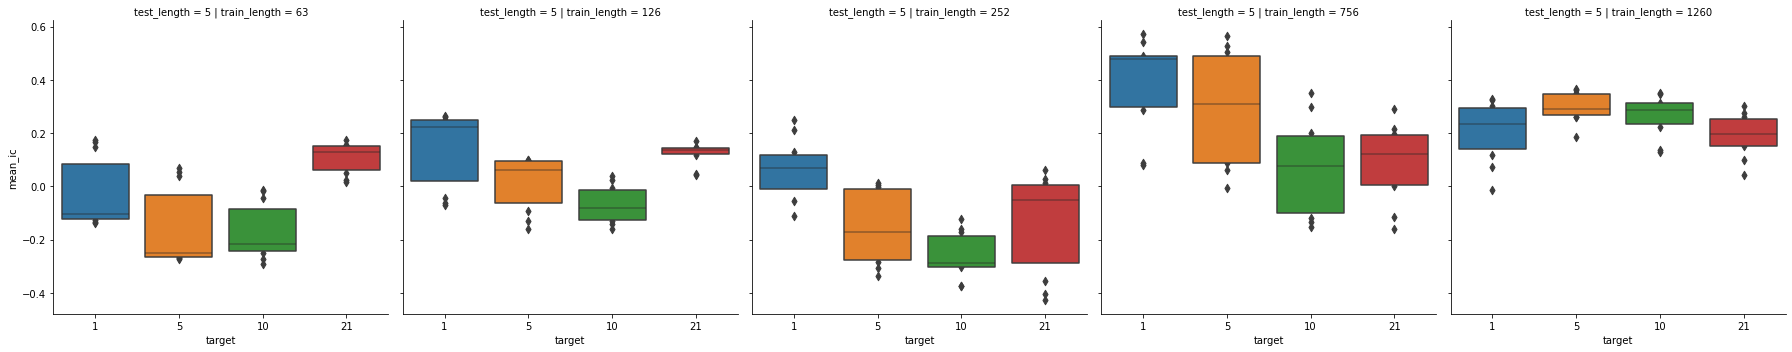

In [36]:
sns.catplot(x='target',
            y='mean_ic',
            col='train_length',
            row='test_length',
            data=cross_val_results[(cross_val_results.test_length == 5)],
            kind='boxen')

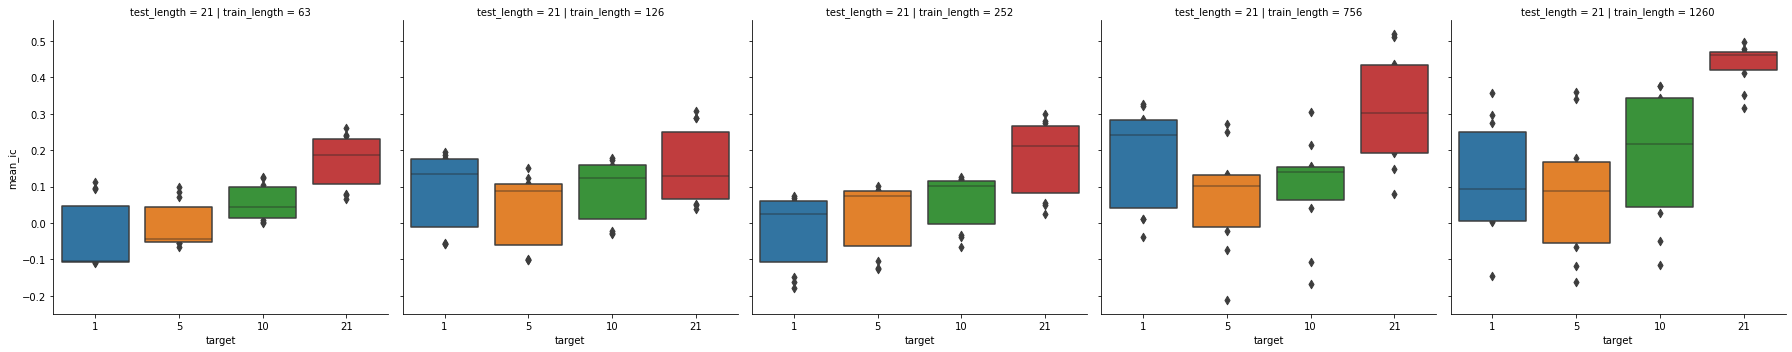

In [37]:
sns.catplot(x='target',
            y='mean_ic',
            col='train_length',
            row='test_length',
            data=cross_val_results[(cross_val_results.test_length == 21)],
            kind='boxen')

As we can see the longer the train periods are the better, the `mean_ic` steadly grows as the train period grows. If
we look also to the test period the previous logic is still true.

Regarding the standard deviation of the `ic` we can see a great decrease when the test length is longer, while the
train period doesn't seem to affect positively the standard deviation.

In [38]:
hyperparam_res = cross_val_results.groupby(by=['n_estimators', 'max_depth', 'min_samples_leaf'])

hyperparam_res.describe()

mean_ic                                \
                                          count      mean       std       min   
n_estimators max_depth min_samples_leaf                                         
100          5         25                  40.0  0.112696  0.167468 -0.304762   
                       100                 40.0  0.033655  0.206255 -0.306349   
             15        5                   40.0  0.096924  0.201646 -0.428822   
                       100                 40.0  0.043086  0.208742 -0.337372   
250          5         5                   40.0  0.083366  0.176167 -0.374937   
                       25                  40.0  0.138520  0.171451 -0.271631   
             15        25                  40.0  0.134515  0.170140 -0.250624   

                                                                       \
                                              25%       50%       75%   
n_estimators max_depth min_samples_leaf                                 
100          5         25                0.015995  0.124628  0.214738   
                       100              -0.107092 -0.008930  0.137314   
             15        5                -0.039396  0.111421  0.216822   
                       100              -0.103896  0.004730  0.200758   
250          5         5                 0.015174  0.098287  0.159225   
                       25                0.076970  0.141839  0.233970   
             15        25                0.043229  0.131463  0.222783   

                                                  std_ic                      \
                                              max  count      mean       std   
n_estimators max_depth min_samples_leaf                                        
100          5         25                0.478242   40.0  0.183426  0.129572   
                       100               0.511998   40.0  0.180954  0.129542   
             15        5                 0.543609   40.0  0.202214  0.135985   
                       100               0.470568   40.0  0.193624  0.136061   
250          5         5                 0.496082   40.0  0.192481  0.137085   
                       25                0.481203   40.0  0.178882  0.132178   
             15        25                0.572932   40.0  0.200999  0.134627   

                                                                            \
                                         min       25%       50%       75%   
n_estimators max_depth min_samples_leaf                                      
100          5         25                0.0  0.056950  0.193997  0.288662   
                       100               0.0  0.101512  0.168112  0.293761   
             15        5                 0.0  0.080639  0.219055  0.322401   
                       100               0.0  0.108921  0.177342  0.325166   
250          5         5                 0.0  0.037553  0.203550  0.325307   
                       25                0.0  0.057442  0.178475  0.287820   
             15        25                0.0  0.116917  0.207180  0.308394   

                                                   
                                              max  
n_estimators max_depth min_samples_leaf            
100          5         25                0.435829  
                       100               0.437056  
             15        5                 0.402256  
                       100               0.445483  
250          5         5                 0.381254  
                       25                0.419272  
             15        25                0.425666

By giving a first look to the hyperparameters results, we can see that a larger number of estimators
often gives better `ic`, while is not really clear what kind of impact the others two parameters have.

It seems like that a lower number of sample for each leaf often gives a greater `ic`. Let's see if that it is true by
seeing which combination of parameters gives the highest mean ic.

In [39]:
hyperparam_res.apply(lambda x : x.nlargest(3, 'mean_ic')).drop(['n_estimators', 'max_depth', 'min_samples_leaf'], axis=1)

train_length test_length  \
n_estimators max_depth min_samples_leaf                                
100          5         25               318         1260          21   
                                        28           756           5   
                                        208         1260           5   
                       100              333          756          21   
                                        313         1260          21   
                                        213         1260          21   
             15        5                20           756           5   
                                        120          756           5   
                                        310         1260          21   
                       100              319         1260          21   
                                        109         1260           5   
                                        119         1260          21   
250          5         5                317         1260          21   
                                        337          756          21   
                                        27           756           5   
                       25               24           756           5   
                                        314         1260          21   
                                        334          756          21   
             15        25               22           756           5   
                                        122          756           5   
                                        202         1260           5   

                                              mean_ic    std_ic rounds target  
n_estimators max_depth min_samples_leaf                                        
100          5         25               318  0.478242  0.000000      1     21  
                                        28   0.477444  0.110526      2      1  
                                        208  0.302256  0.000000      1     10  
                       100              333  0.511998  0.171003      2     21  
                                        313  0.466781  0.000000      1     21  
                                        213  0.377463  0.000000      1     10  
             15        5                20   0.543609  0.208271      2      1  
                                        120  0.444361  0.051880      2      5  
                                        310  0.411279  0.000000      1     21  
                       100              319  0.470568  0.000000      1     21  
                                        109  0.360902  0.000000      1      5  
                                        119  0.359279  0.000000      1      5  
250          5         5                317  0.496082  0.000000      1     21  
                                        337  0.425261  0.175347      2     21  
                                        27   0.325564  0.002256      2      1  
                       25               24   0.481203  0.124812      2      1  
                                        314  0.463339  0.000000      1     21  
                                        334  0.435294  0.175823      2     21  
             15        25               22   0.572932  0.169925      2      1  
                                        122  0.503759  0.127820      2      5  
                                        202  0.347368  0.000000      1     10

From the table above we can see that the combinations which gives the best results are `{'n_estimators': 100, 'max_depth':15, 'min_samples_leaf': 100}` and
`{'n_estimators': 250, 'max_depth':15, 'min_samples_leaf': 100}`.

Contrary from what we've supposed before `min_sample_leaf` has to be big in order to achive higher `ic`, maybe because
this parameter can allow building more generalized trees.

`n_estimators` parameter doesn't seem to make a big difference in the model, since the result that
we get from the combinations cited above are almost the same, indeed the model with fewer trees performs better
than the one with more trees.


In [40]:
res_target = cross_val_results.groupby(by='target')

res_target.describe()

mean_ic                                                              \
         count      mean       std       min       25%       50%       75%   
target                                                                       
1        100.0  0.110004  0.177280 -0.178952 -0.047236  0.095672  0.240913   
5        100.0  0.048479  0.195447 -0.337372 -0.078053  0.061785  0.123598   
10       100.0  0.032228  0.188048 -0.375439 -0.118175  0.038809  0.145735   
21       100.0  0.163042  0.176055 -0.428822  0.058735  0.155303  0.259631   

                 std_ic                                               \
             max  count      mean       std  min       25%       50%   
target                                                                 
1       0.572932  100.0  0.174398  0.123602  0.0  0.091984  0.167695   
5       0.565414  100.0  0.182694  0.135893  0.0  0.046941  0.175785   
10      0.377463  100.0  0.199149  0.128145  0.0  0.143750  0.209543   
21      0.519611  100.0  0.207492  0.138582  0.0  0.073872  0.231521   

                            
             75%       max  
target                      
1       0.290047  0.388710  
5       0.307571  0.435829  
10      0.307754  0.445483  
21      0.323146  0.437056

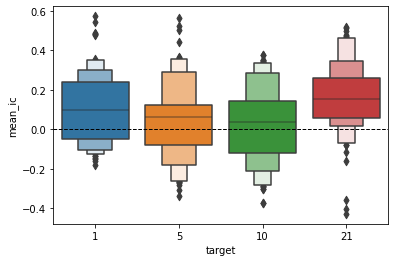

In [41]:
ax = sns.boxenplot(x='target', y='mean_ic', data=cross_val_results)
ax.axhline(0, ls='--', lw=1, c='k')

Now that we've grouped by target (the lookhead of our model) let's see that our previous hypothesis about
the best hyperparameters that we've done before are confirmed.

In [42]:
res_target.apply(lambda x: x.nlargest(3, 'mean_ic')).drop('target', axis=1)

train_length test_length n_estimators max_depth min_samples_leaf  \
target                                                                        
1      22           756           5          250        15               25   
       20           756           5          100        15                5   
       25           756           5          250      None                5   
5      125          756           5          250      None                5   
       126          756           5          100      None               25   
       122          756           5          250        15               25   
10     213         1260          21          100         5              100   
       211         1260          21          250      None              100   
       220          756           5          100        15                5   
21     331          756          21          250      None              100   
       333          756          21          100         5              100   
       317         1260          21          250         5                5   

             mean_ic    std_ic rounds  
target                                 
1      22   0.572932  0.169925      2  
       20   0.543609  0.208271      2  
       25   0.490226  0.206015      2  
5      125  0.565414  0.105263      2  
       126  0.525564  0.068421      2  
       122  0.503759  0.127820      2  
10     213  0.377463  0.000000      1  
       211  0.375478  0.000000      1  
       220  0.350376  0.090226      2  
21     331  0.519611  0.054470      2  
       333  0.511998  0.171003      2  
       317  0.496082  0.000000      1

In [43]:
res_std = cross_val_results[cross_val_results.std_ic != 0.0].groupby(by='target')
res_std.apply(lambda x: x.nsmallest(3, 'std_ic')).drop('target', axis=1)

train_length test_length n_estimators max_depth min_samples_leaf  \
target                                                                        
1      27           756           5          250         5                5   
       34           756          21          250         5               25   
       39           756          21          100        15              100   
5      138          756          21          100         5               25   
       135          756          21          250      None                5   
       130          756          21          100        15                5   
10     237          756          21          250         5                5   
       233          756          21          100         5              100   
       231          756          21          250      None              100   
21     327          756           5          250         5                5   
       326          756           5          100      None               25   
       331          756          21          250      None              100   

             mean_ic    std_ic rounds  
target                                 
1      27   0.325564  0.002256      2  
       34   0.131173  0.007958      2  
       39   0.326385  0.018153      2  
5      138  0.248810  0.015116      2  
       135 -0.073048  0.017019      2  
       130 -0.212686  0.024026      2  
10     237  0.134889  0.014873      2  
       233  0.214601  0.068359      2  
       231  0.305629  0.077807      2  
21     327  0.157895  0.045113      2  
       326  0.214286  0.051880      2  
       331  0.519611  0.054470      2

Guess what? Out hypothesis are confirmed!

The best models have all the best hyperparameters that we've identified before:

`{'n_estimators': 100, 'max_depth':15, 'min_samples_leaf': 100, train_length: 1260, test_length:21}`

In [44]:
base_params = rf_reg.get_params()
model = RandomForestRegressor(base_params)
model_params = {
    'n_estimators': 250,
    'max_depth': None,
    'max_features': 'log2',
    'min_samples_leaf': 100
}
model = model.set_params(**model_params)
opt_test_length = 21
opt_train_length = 756

In [45]:
scores = np.array([])

for lookahead in lookaheads:
    n_splits = int(7 * YEAR /  (opt_test_length + opt_train_length))
    cv = MultipleTimeSeriesCV(
        n_splits=n_splits,
        test_period_length=opt_test_length,
        train_period_length=opt_train_length,
        lookahead=lookahead
    )

    for i, (train_idx, test_idx) in enumerate(cv.split(X)):
        model = model.fit(X.iloc[train_idx], y[f'target_{lookahead}d'].iloc[train_idx])

        y_test = y[f'target_{lookahead}d'].iloc[test_idx]
        y_pred = model.predict(X.iloc[test_idx])
        scores = np.append(scores, rank_correl(y_test, y_pred))
        print(f'Lookhead: {lookahead} | Iteration: {i} | Val score: {scores[-1]}')

Lookhead: 1 | Iteration: 0 | Val score: 0.37272727272727274
Lookhead: 1 | Iteration: 1 | Val score: 0.13376623376623376
Lookhead: 5 | Iteration: 0 | Val score: 0.5779220779220778
Lookhead: 5 | Iteration: 1 | Val score: 0.43585582032439013
Lookhead: 10 | Iteration: 0 | Val score: 0.19291978932391035
Lookhead: 10 | Iteration: 1 | Val score: 0.19505868247886227
Lookhead: 21 | Iteration: 0 | Val score: 0.34372976716900616
Lookhead: 21 | Iteration: 1 | Val score: 0.5475804121214021


## Evaluate the Best Model

In [53]:
y_test = data.filter(like='target').loc['2019': '2021']

y_test

,target_1d,target_5d,target_10d,target_21d
Date,,,,
2019-01-02,-0.004395,0.001752,0.013545,-0.003743
2019-01-03,0.033616,0.001625,0.014858,-0.004835
2019-01-04,-0.032852,0.003588,0.013534,-0.006365
2019-01-07,0.007812,0.040532,0.003214,-0.004783
2019-01-08,0.005730,0.033653,0.000437,-0.007168
...,...,...,...,...
2021-08-24,0.000257,0.023556,0.023485,0.011719
2021-08-25,0.073646,0.034399,0.025870,0.013270
2021-08-26,0.044455,0.020949,0.016707,0.014884


In [67]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_1d.values[-30:]))

0.08272038398896059


In [54]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_5d.values[-30:]))

0.181717285582218


In [68]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_10d.values[-30:]))

0.5723537080853419


In [55]:
print(rank_correl(model.predict(X_test.iloc[-30:]), y_test.target_21d.values[-30:]))


0.357414489310792


## Parameters importance

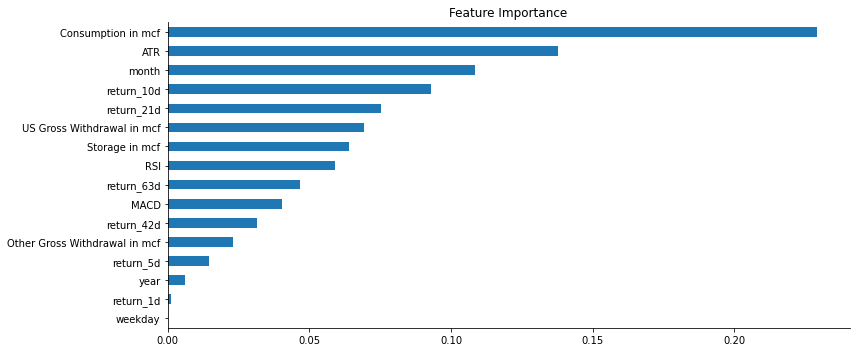

In [56]:

fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(model.feature_importances_, index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='Feature Importance'))

sns.despine()

fig.tight_layout();

Using the builtin `features_importances_` attribute from our model we can see that the most impactful params are:

- ATR
- NG consumption
- Other States Gross Withdrawal
- US Gross Withdrawal
- year
- MACD

To have a more holistic view of the importance of the features, we can use two others functions provided by
sklearn: `permutation_importance` and `partial_dependence`.

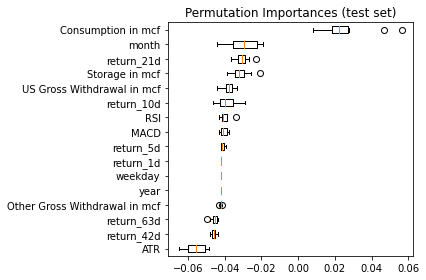

In [57]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay, partial_dependence

result = permutation_importance(model, X_test, y_test.target_21d, n_repeats=10, n_jobs=-1, max_samples=0.3)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

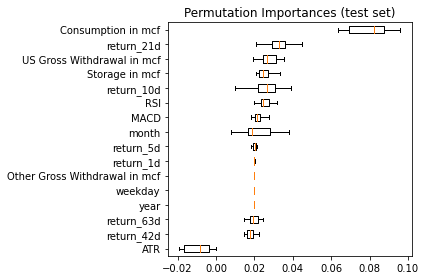

In [58]:
result = permutation_importance(model, X_test, y_test.target_21d, n_repeats=10, n_jobs=-1, max_samples=0.3)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Partial dependence

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest,
marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

### Partial dependence between the ATR and MACD

What is really significant in the image below is the gap in the partial dependence values when the approaches values
between 0.16 and 0.14.

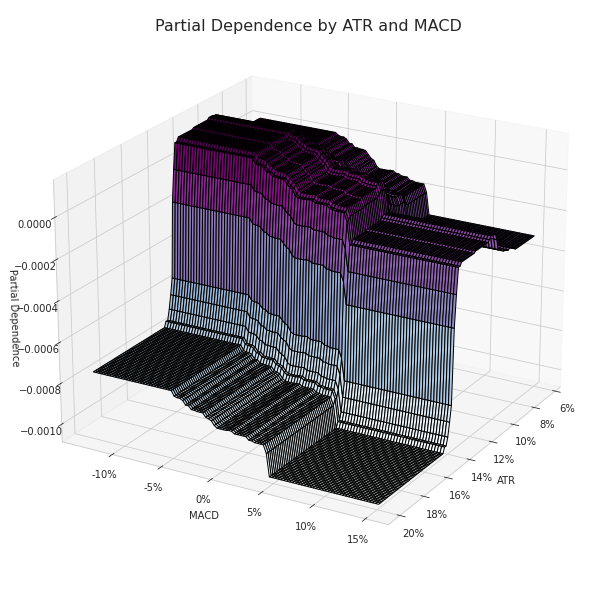

In [59]:
sns.set_style('whitegrid')
targets = ['ATR', 'MACD']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('ATR')
ax.set_ylabel('MACD')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by ATR and MACD', fontsize=16)
fig.tight_layout()

### Partial dependence between the Consumption and Storage

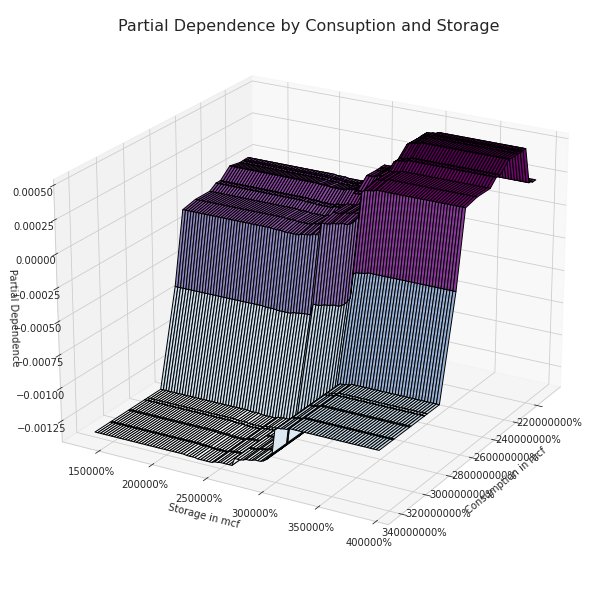

In [60]:
sns.set_style('whitegrid')
targets = ['Consumption in mcf', 'Storage in mcf']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('Consumption in mcf')
ax.set_ylabel('Storage in mcf')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by Consuption and Storage', fontsize=16)
fig.tight_layout()

### Partial Dependence between 10 and 21 return days

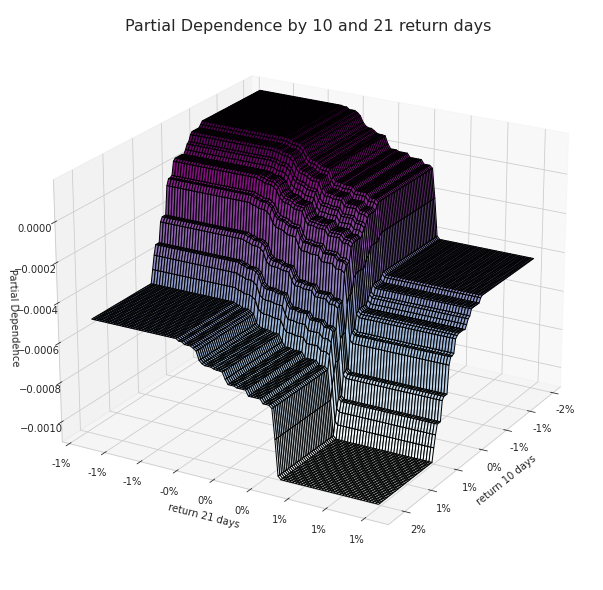

In [61]:
sns.set_style('whitegrid')
targets = ['return_10d', 'return_21d']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z,
                    rstride=1,
                    cstride=1,
                    cmap=plt.cm.BuPu,
                    edgecolor='k')
ax.set_xlabel('return 10 days')
ax.set_ylabel('return 21 days')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

fig.suptitle('Partial Dependence by 10 and 21 return days', fontsize=16)
fig.tight_layout()

### Partial Dependence between 1 and 5 return days


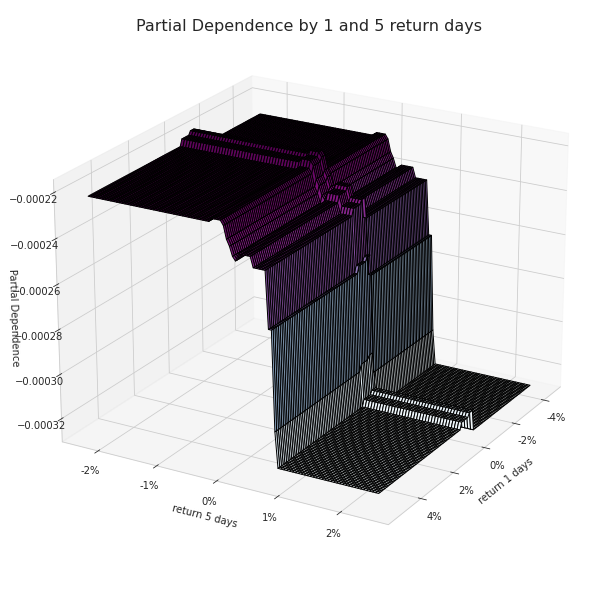

In [62]:
sns.set_style('whitegrid')
targets = ['return_1d', 'return_5d']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z,
                    rstride=1,
                    cstride=1,
                    cmap=plt.cm.BuPu,
                    edgecolor='k')
ax.set_xlabel('return 1 days')
ax.set_ylabel('return 5 days')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

fig.suptitle('Partial Dependence by 1 and 5 return days', fontsize=16)
fig.tight_layout()

### Partial Dependence between NG Consuption and ATR

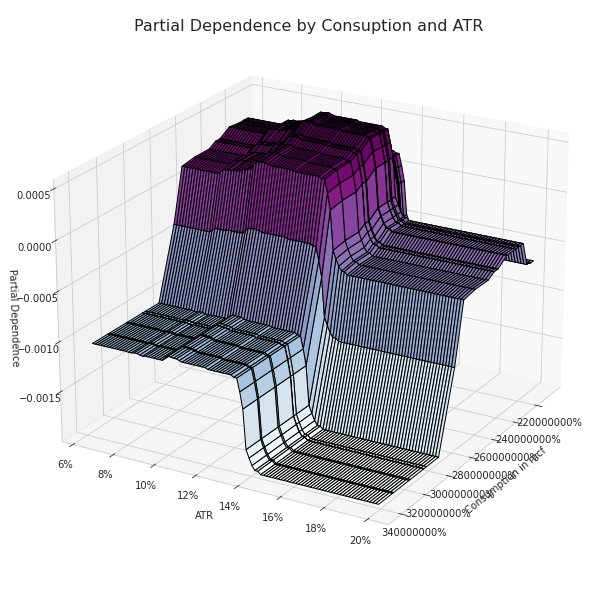

In [63]:
sns.set_style('whitegrid')
targets = ['Consumption in mcf', 'ATR']
pdp, axes = partial_dependence(estimator=model,
                               features=targets,
                               X=X_test,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('Consumption in mcf')
ax.set_ylabel('ATR')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

fig.suptitle('Partial Dependence by Consuption and ATR', fontsize=16)
fig.tight_layout()

Comparing the two most important features identified before (the ATR and the Consumption) we can clearly
we can see not only higher values but also a well-defined pattern regarding partial dependence.
As the ATR and the Consuption are approaching lower values the partial dependence grows, the opposite happens
when the opposite conditions occur.

## Shap Values

Shapley values originated in game theory as a technique for assigning a value to each player in a collaborative game
that reflects their contribution to the team's success. SHAP values are an adaptation of the game theory concept to
tree-based models and are calculated for each feature and each sample. They measure how a feature contributes to the
model output for a given observation. For this reason, SHAP values provide differentiated insights into how the impact
of a feature varies across samples, which is important given the role of interaction effects in these nonlinear models.



Shapley values are computed by introducing each feature, one at a time, into a conditional expectation function of the
model’s output, $$f_x(S) = \mathbb{E}[f(X) | do(X_s = x_s)]$$, and attributing the change produced at each step to the feature that was introduced; then averaging this process over all possible feature orderings.

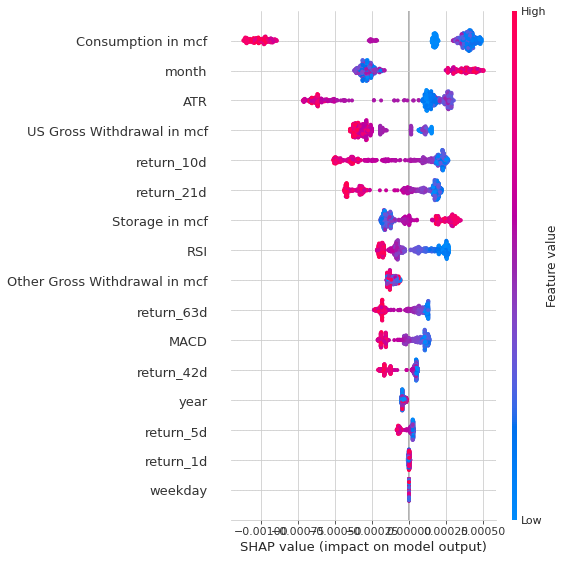

In [64]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X=X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()

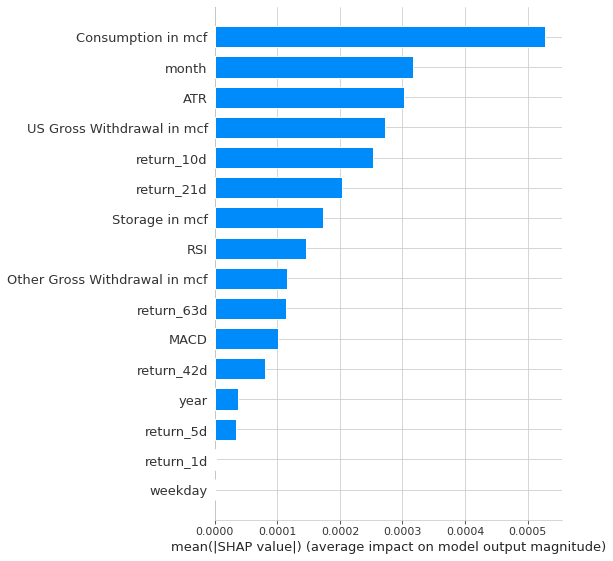

In [65]:

shap.summary_plot(shap_values, X_test, plot_type="bar",show=False)
plt.tight_layout()

The Shap values that we are seeing in the two images are confirming the most important features that
we've identified before, which are: ATR, Consumption, Other Gross Withdrawal, US Gross Withdrawal, year and
the MACD.

What Shap values are telling us more is how each feature is positively/negatively impact the output. We can see from
the first picture that:

- lower values of ATR usually lead to better returns, while when the ATR is higher the opposite tend to happend
- we can say the same thing about the Consumption
- later years often yield to higher result
- lower values of MACD are positively correlated to higher model output values, like the atr
- there isn't a direct relationship when we are looking at the Withdrawal values, both higher and lower values seem to gave negative result in most cases

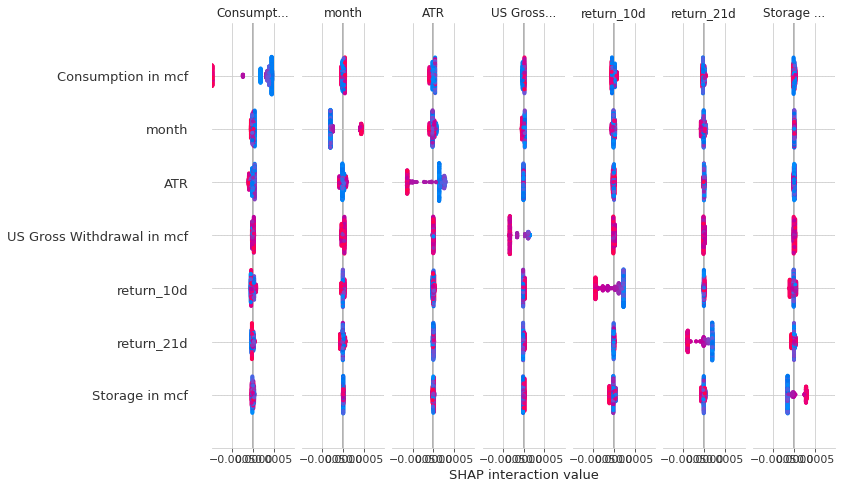

In [66]:
shap_interaction_values = explainer.shap_interaction_values(X_test)

shap.summary_plot(shap_interaction_values, X_test)

TODO:

- [x] Update model data with new data
- [x] Held out a test set used to testing (between 30% and 20% of the total data) and for compute feature importance
- [ ] retrain the model
- Backtest the model using backtesting.py, using only the most important features

# References

- [NHANES I Survival Model](https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html#NHANES-I-Survival-Model)
- [Long-Short Strategy, Part 4: How to interpret GBM results](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/12_gradient_boosting_machines/07_model_interpretation.ipynb)